In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import wilcoxon
from scipy import stats

In [ ]:
########################################################### load climatology dataset ############################################################
clim_z500 = xr.open_dataset('/home/kit/imk-tro/gj5173/tmp/clim_Z50000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')

In [2]:
#data import
ds_era = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/era5/2021.h5')
ds_era
# devided by WMO-defined gravity constant of 9.80665 m/s**2

<xarray.Dataset>
Dimensions:  (phony_dim_0: 1460, phony_dim_1: 20, phony_dim_2: 721,
              phony_dim_3: 1440)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3
Data variables:
    fields   (phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3) float32 ...

In [3]:
ds_era_z500 = ds_era.fields[716,14,260:40:-1,720:1200] #25°N - 80°N, 180°W - 60°W z500
np.shape(ds_era_z500)

(220, 480)

In [4]:
ds_ecmwf = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_cf_20210629_00_pl.nc')
ds_ecmwf.z

<xarray.DataArray 'z' (time: 57, level: 4, latitude: 221, longitude: 481)>
[24236628 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -60.5 -60.25 -60.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 25.5 25.25 25.0
  * level      (level) int32 1000 850 500 50
  * time       (time) datetime64[ns] 2021-06-29 ... 2021-07-13
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [5]:
#ECMWF
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'

files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
files

data_ec = []
for file in files:
    file_path = os.path.join(directory, file)
    # Extract the date from the filename
    #date_str = re.search(r'\d{8}_\d{2}', file).group(0)
    #date = datetime.datetime.strptime(date_str, '%Y%m%d_%H').date()
    # Read the file and extract the desired variable
    ds = xr.open_dataset(file_path)
    variable_data = ds['z'][:,2,:,:]

    #time_coord = xr.DataArray([date], dims='time1', coords={'time1': [date]})
    #variable_data = variable_data.expand_dims(dim='time1')
    #variable_data = variable_data.assign_coords(time=time_coord)

    data_ec.append(variable_data)

#combined_data = xr.concat(data, dim='time1')
#combined_data
#combined_data[0,:,119,234]
np.shape(data_ec)

#ds_ecmwf.t2m[0,79:159,194:274]
data_array_ec =xr.DataArray(data_ec)
#data_array_ec[:,0,0,0]
#mean_ecmwf = np.mean(data_array_ec[:,:,79:159,194:274], axis=(-2, -1))
#mean_ecmwf

In [7]:
start_index = 56
step_size = 1
num_iterations =15
ec_values=[]
for i in range(num_iterations):
    ec_value = data_array_ec[(i+1) * step_size, start_index - i * step_size*4,:,:]
    ec_values.append(ec_value)
data_array_ec_values =xr.DataArray(ec_values)

In [8]:
#fcn_ecmwf
directory_fcn_ec = '/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/'
filename_pattern_fcn_ec = r'\d{8}_00_backtransformed\.nc'
#fc_cf_20210615_00_sfc.nc
#20210704_00_backtransformed.nc
files_fcn_ec = sorted([f for f in os.listdir(directory_fcn_ec) if re.match(filename_pattern_fcn_ec, f)])
files_fcn_ec

data_fcn_ec = []
for file1 in files_fcn_ec:
    file_path_fcn_ec = os.path.join(directory_fcn_ec, file1)
    # Extract the date from the filename
    date_str = re.search(r'\d{8}', file1).group(0)
    
    date = datetime.datetime.strptime(date_str, '%Y%m%d').date()
    # Read the file and extract the desired variable
    ds_fcn_ec = xr.open_dataset(file_path_fcn_ec)
    variable_data_fcn_ec =  ds_fcn_ec['forecast'][50,:,14,:,:]
    data_fcn_ec.append(variable_data_fcn_ec)

data_array_fcn_ec =xr.DataArray(data_fcn_ec)    

#mean_fcn_ec = np.mean(data_array_fcn_ec, axis=(-2, -1))
#mean_fcn_ec
np.shape(data_array_fcn_ec)

(21, 57, 220, 480)

In [9]:
start_index = 56
step_size = 1
num_iterations =15
fcn_ec_values=[]
for i in range(num_iterations):
    fcn_ec_value = data_array_fcn_ec[(i+1) * step_size, start_index - i * step_size*4,:,:]
    fcn_ec_values.append(fcn_ec_value)
data_array_fcn_ec_values =xr.DataArray(fcn_ec_values)
#data_array_fcn_ec_values[14,:,:] = data_array_ec_values[14,:,:]
#replace the missing data

In [10]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
mean_fcn_era = ds_fcn_era.forecast[:,0,:,14,:,:]
mean_fcn_era
start_index = 56
step_size = 1
num_iterations =15
fcn_era_values=[]
for i in range(num_iterations):
    fcn_era_value = mean_fcn_era[(i+1) * step_size, start_index - i * step_size*4]
    fcn_era_values.append(fcn_era_value)
data_array_fcn_era_values=xr.DataArray(fcn_era_values)
np.shape(data_array_fcn_era_values)
#data_array_fcn_era_values

(15, 220, 480)

In [ ]:
%store -r 

In [11]:
#use smaller batches to calculate the difference(cuz direct calculation is not possible)
variable1_ec_14 = ds_era_z500.values
variable2_ec_14 = data_array_ec_values[0,221:0:-1,0:480].values
variable3_ec_14 = data_array_fcn_ec_values[0,::-1,:].values
variable4_ec_14 = data_array_fcn_era_values[0,::-1,:].values
np.shape(variable3_ec_14)

#np.shape(variable2_1) 5 
variable1_ec_7 = ds_era_z500.values
variable2_ec_7 = data_array_ec_values[7,221:0:-1,0:480].values
variable3_ec_7 = data_array_fcn_ec_values[7,::-1,:].values
variable4_ec_7 = data_array_fcn_era_values[7,::-1,:].values
variable1_ec_3 = ds_era_z500.values
variable2_ec_3 = data_array_ec_values[11,221:0:-1,0:480].values
variable3_ec_3 = data_array_fcn_ec_values[11,::-1,:].values
variable4_ec_3 = data_array_fcn_era_values[11,::-1,:].values

In [12]:
np.shape(variable2_ec_14)

(220, 480)

In [13]:
batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference_ec_14 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_14 = variable1_ec_14[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_14 = variable2_ec_14[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_14 =  batch_variable2_ec_14-batch_variable1_ec_14 
        
        # Update the difference array with the current batch_difference
        difference_ec_14[i:i + batch_size, j:j + batch_size] = batch_difference_ec_14

In [14]:
batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference_fcn_ec_14 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_14 = variable1_ec_14[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_14 = variable3_ec_14[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_14 = batch_variable3_ec_14 - batch_variable1_ec_14 
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_14[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_14

In [15]:
batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference_fcn_era_14 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_14 = variable1_ec_14[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_14 = variable4_ec_14[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_14 = batch_variable4_ec_14 - batch_variable1_ec_14 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_14[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_14

In [16]:
difference_ec_7 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_7 = variable1_ec_7[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_7 = variable2_ec_7[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_7 = batch_variable2_ec_7 - batch_variable1_ec_7 
        
        # Update the difference array with the current batch_difference
        difference_ec_7[i:i + batch_size, j:j + batch_size] = batch_difference_ec_7

In [17]:
difference_fcn_ec_7 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_7 = variable1_ec_7[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_7 = variable3_ec_7[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_7 = batch_variable3_ec_7 - batch_variable1_ec_7
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_7[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_7

In [18]:
difference_fcn_era_7 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_7 = variable1_ec_7[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_7 = variable4_ec_7[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_7 = batch_variable4_ec_7 - batch_variable1_ec_7 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_7[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_7

In [19]:
difference_ec_3 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_3 = variable1_ec_3[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_3 = variable2_ec_3[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_3 = batch_variable2_ec_3 - batch_variable1_ec_3 
        
        # Update the difference array with the current batch_difference
        difference_ec_3[i:i + batch_size, j:j + batch_size] = batch_difference_ec_3

In [20]:
difference_fcn_ec_3 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_3 = variable1_ec_3[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_3 = variable3_ec_3[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_3 =  batch_variable3_ec_3 - batch_variable1_ec_3
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_3[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_3

In [21]:
difference_fcn_era_3 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_3 = variable1_ec_3[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_3 = variable4_ec_3[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_3 = batch_variable4_ec_3 - batch_variable1_ec_3 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_3[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_3

In [22]:
ds_era_z500_1d = np.reshape(ds_era_z500,(1,220*480))
data_array_ec_values_1d = np.reshape(data_array_ec_values[0,221:0:-1,0:480],(1,220*480))
difference_ec_14_1d = np.reshape(difference_ec_14/9.80665,(1,220*480))

In [23]:
ds_era_z500_1d

<xarray.DataArray 'fields' (phony_dim_2: 1, phony_dim_3: 105600)>
array([[58135.543, 58132.29 , 58129.03 , ..., 52461.426, 52461.426,
        52461.426]], dtype=float32)
Dimensions without coordinates: phony_dim_2, phony_dim_3

In [24]:
data_array_ec_values_1d

<xarray.DataArray (dim_1: 1, dim_2: 105600)>
array([[57895.7  , 57894.2  , 57892.824, ..., 54482.7  , 54477.324,
        54472.074]], dtype=float32)
Dimensions without coordinates: dim_1, dim_2

In [25]:
difference_ec_14_1d_r = np.round(difference_ec_14_1d)
np.shape(difference_ec_14_1d_r)

(1, 105600)

In [26]:
w_test = wilcoxon(difference_ec_14_1d,data_array_ec_values_1d)
w_test

WilcoxonResult(statistic=array([0., 0., 0., ..., 0., 0., 0.]), pvalue=array([1., 1., 1., ..., 1., 1., 1.]))

In [27]:
ttest_ec_14 = stats.ttest_ind(ds_era_z500,data_array_ec_values[0,221:0:-1,0:480],equal_var=True)

In [28]:
np.shape(data_array_ec_values[0,221:0:-1,0:480])

(220, 480)

In [29]:
t_stat, p_values = stats.ttest_ind(ds_era_z500, data_array_ec_values[0,221:0:-1,0:480])

In [30]:
np.shape(p_values)

(480,)

In [31]:
alpha = 0.05
significant_points = ttest_ec_14.pvalue < alpha

In [32]:
x, y = np.meshgrid(np.arange(difference_ec_14.shape[1]), np.arange(difference_ec_14.shape[0]))

In [33]:
#plt.scatter(x[significant_points], y[significant_points], c='red', marker='x', s=50, label='Significant Difference')

In [34]:
pvalue_ec_14 = np.reshape(w_test.pvalue,(220,480))

In [35]:
data1 = ds_era_z500
data2 = data_array_ec_values[0,221:0:-1,0:480]

# Initialize an empty array for p-values with the same shape
p_values = np.empty(data1.shape)

# Iterate through the rows and conduct t-tests
for i in range(data1.shape[0]):
    t_stat, p_values[i, :] = stats.ttest_ind(data1[i, :], data2[i, :])


In [36]:
alpha = 0.05
significant_points = p_values < alpha

In [74]:
x, y = np.meshgrid(np.arange(difference_ec_14.shape[1]), np.arange(difference_ec_14.shape[0]))

In [93]:
print(significant_points[29,:])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

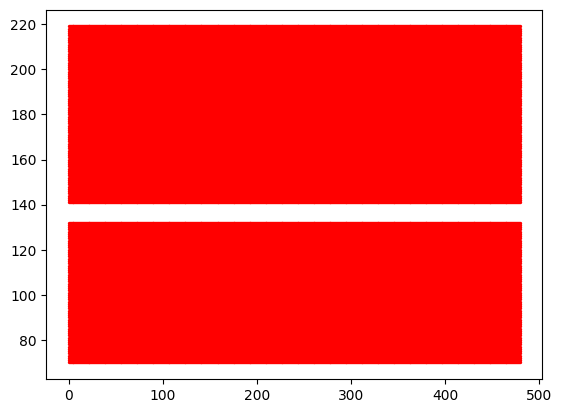

In [95]:
plt.scatter(x[significant_points],y[significant_points],c='red', marker='o', s=2, label='Significant Difference')

In [38]:
lat = np.linspace(25, 80, 220)
lon = np.linspace(-180, -60, 480)
lon_grid, lat_grid = np.meshgrid(lon, lat)
x, y = lon_grid, lat_grid  

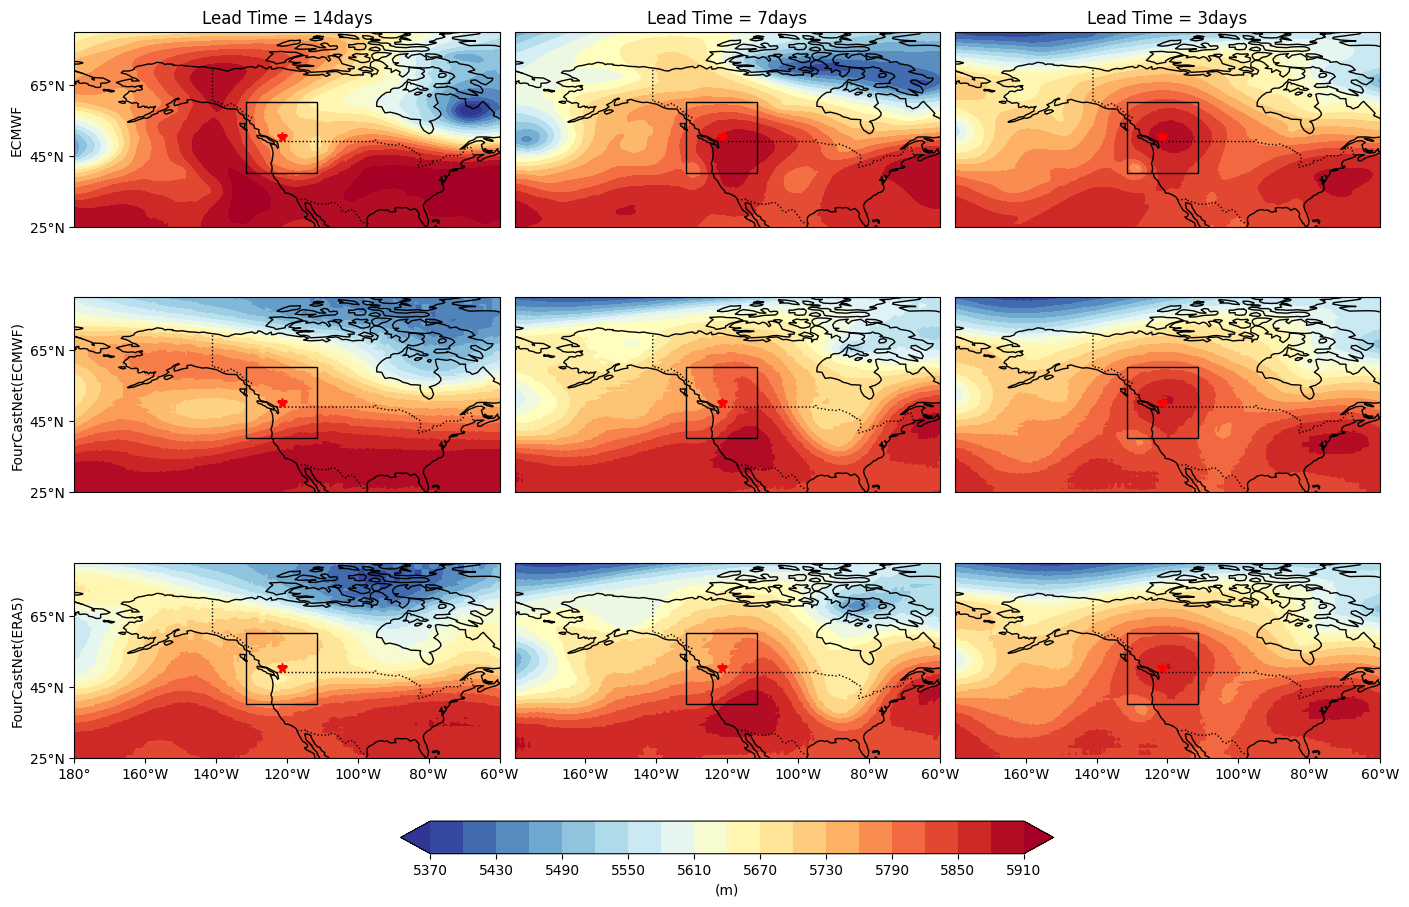

In [40]:
#check if the abnormal sst problem is caused by clor bar settings


#create t2m plots with 9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = 'RdYlBu_r'
                                                 

#vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())
#vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
#norm = TwoSlopeNorm(vmin=variable2_ec_14.min(), vmax=variable2_ec_14.max() )
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap,levels = 20)
#cmap=cmap, norm=norm
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
red_point_lon = -121.50
red_point_lat = 50.25

rect = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_2 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_3 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_4 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_5 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_6 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_7 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_8 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')


#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,data_array_ec_values[0,221:0:-1,0:480].values/9.80665 ,**plot_kwargs,extend='both')
ax1.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax1.add_patch(rect)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')



ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 7days')
contour2 = ax2.contourf(x,y,data_array_ec_values[7,221:0:-1,0:480]/9.80665,**plot_kwargs)
ax2.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax2.add_patch(rect_1)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')



# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 3days')
contour3 = ax3.contourf(x,y,data_array_ec_values[11,221:0:-1,0:480]/9.80665,**plot_kwargs)
ax3.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax3.add_patch(rect_2)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480

#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')



ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,data_array_fcn_ec_values[0,::-1,:].values/9.80665,**plot_kwargs)
ax4.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax4.add_patch(rect_3)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FourCastNet(ECMWF)')
plt.tight_layout()


#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,data_array_fcn_ec_values[7,::-1,:].values/9.80665,**plot_kwargs)
ax5.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax5.add_patch(rect_4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,data_array_fcn_ec_values[11,::-1,:].values/9.80665,**plot_kwargs)
ax6.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax6.add_patch(rect_5)



ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FourCastNet(ERA5)')
contour4 = ax7.contourf(x,y,data_array_fcn_era_values[0,::-1,:],**plot_kwargs)
ax7.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax7.add_patch(rect_6)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,data_array_fcn_era_values[7,::-1,:]/9.80665,**plot_kwargs)
ax8.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax8.add_patch(rect_7)


ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,data_array_fcn_era_values[11,::-1,:]/9.80665,**plot_kwargs)
ax9.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax9.add_patch(rect_8)

#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
#cbar = plt.colorbar(contour1, ax=axs, orientation='vertical', cmap=cmap, norm=norm, shrink=0.6)
#plt.savefig('/home/kit/imk-tro/gj5173/29.08_modified/3*3_difference_t2m.png', bbox_inches='tight',dpi=100)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
cbar = fig.colorbar(contour1, ax=axs,label='(m)', orientation='horizontal',shrink=0.5,pad=0.05, extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/06.09_modified-plts/3*3_z500.png', bbox_inches='tight',dpi=100)

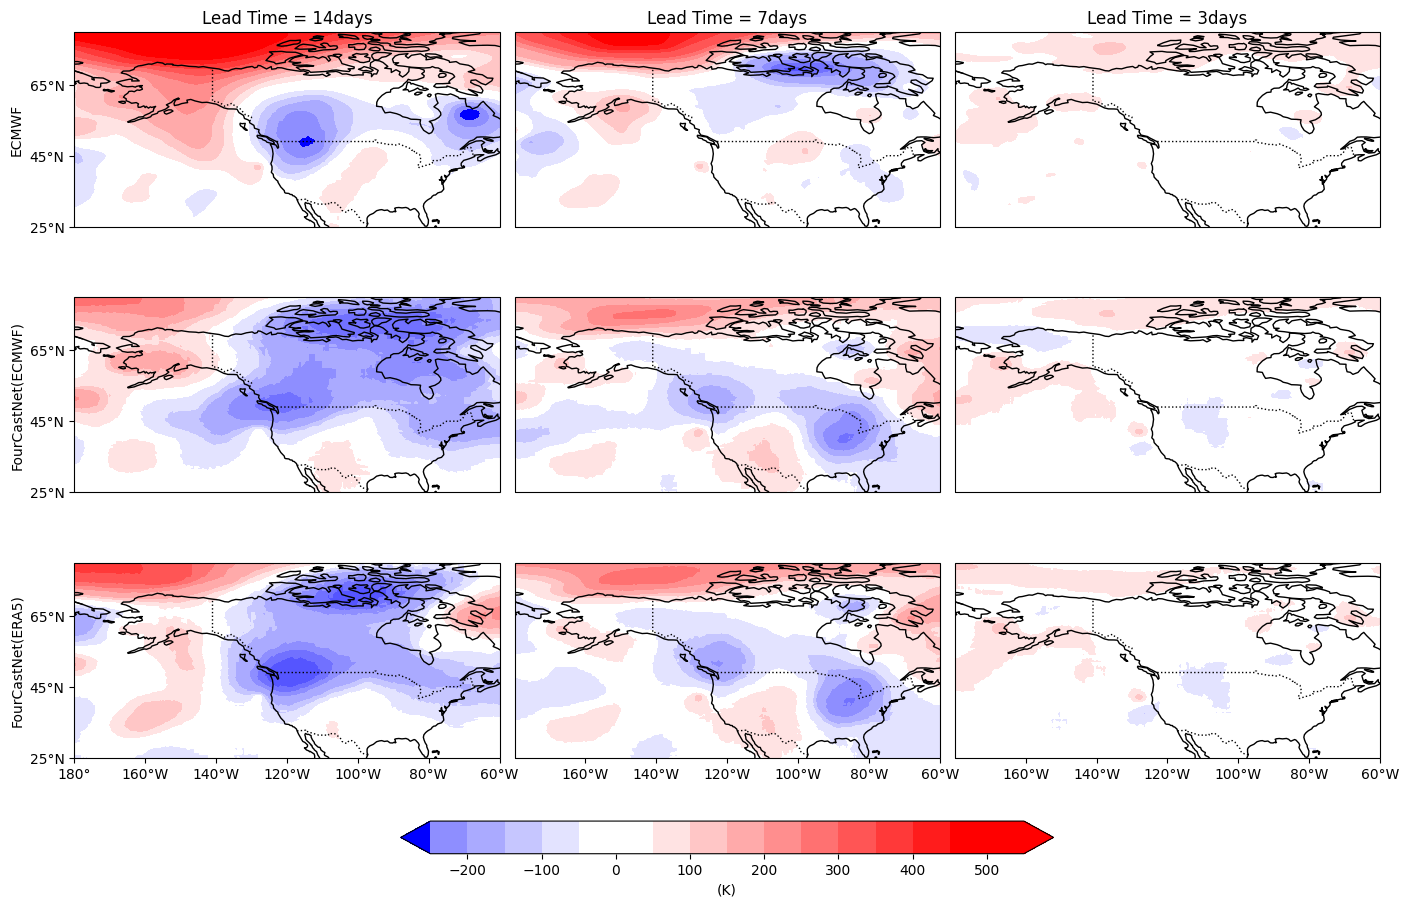

In [48]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=19,
                                                 )



#vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())/9.80665
#vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())/9.80665
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
#norm = TwoSlopeNorm(vmin=-500, vcenter=0, vmax=100)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap,levels = 20,vmin = -500,vmax = 500)
#cmap=cmap, norm=norm8
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,difference_ec_14/9.80665,**plot_kwargs,extend = 'both')
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')



ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 7days')
contour2 = ax2.contourf(x,y,difference_ec_7/9.80665,**plot_kwargs)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 3days')
contour3 = ax3.contourf(x,y,difference_ec_3/9.80665,**plot_kwargs)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480

#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,difference_fcn_ec_14/9.80665,**plot_kwargs)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FourCastNet(ECMWF)')
plt.tight_layout()


#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,difference_fcn_ec_7/9.80665,**plot_kwargs)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,difference_fcn_ec_3/9.80665,**plot_kwargs)

ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FourCastNet(ERA5)')
contour4 = ax7.contourf(x,y,difference_fcn_era_14/9.80665,**plot_kwargs)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,difference_fcn_era_7/9.80665,**plot_kwargs)


ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,difference_fcn_era_3/9.80665,**plot_kwargs)

#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, norm=norm, shrink=0.5,label='(K)',pad = 0.05,extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/29.08_modified/3*3_difference_z500.png', bbox_inches='tight',dpi=100)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)